In [71]:
import torch

words = open("names.txt", "r").read().splitlines()
chars = sorted(list(set("".join(words))))
stoi = {c: i for i, c in enumerate(chars)}
stoi['.'] = 0
itos = {i: c for c, i in stoi.items()}


# build the dataset

def build_dataset(words, block_size=8):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    return torch.tensor(X), torch.tensor(Y)


import random

random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

Xtrain, Ytrain = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

In [70]:
for x, y in zip(Xtrain[:20], Ytrain[:20]):
    print("".join(itos[i.item()] for i in x), itos[y.item()])

........ y
.......y u
......yu h
.....yuh e
....yuhe n
...yuhen g
..yuheng .
........ d
.......d i
......di o
.....dio n
....dion d
...diond r
..diondr e
.diondre .
........ x
.......x .
......x. v
.....x.v i
....x.vi e


In [77]:
import torch

g = torch.Generator().manual_seed(42)


class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.W = torch.randn(fan_in, fan_out, generator=g) / fan_in ** 0.5
        self.b = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.W
        if self.b is not None:
            self.out += self.b
        return self.out

    def parameters(self):
        return [self.W] + ([] if self.b is None else [self.b])


class BatchNorm:
    def __init__(self, n_in, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.n_in = n_in
        self.gamma = torch.ones(n_in)
        self.beta = torch.zeros(n_in)
        self.running_mean = torch.zeros(n_in)
        self.running_var = torch.ones(n_in)

    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            else:
                raise ValueError("expected 2D or 3D input (got {}D input)".format(x.ndim))
            xmean = x.mean(dim=dim, keepdim=True)
            xvar = x.var(dim=dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / (xvar + self.eps) ** 0.5
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = self.momentum * xmean + (1 - self.momentum) * self.running_mean
                self.running_var = self.momentum * xvar + (1 - self.momentum) * self.running_var
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

class Embedding:
    
    def __init__(self, num_embeddings, embedding_dim, padding_idx=None, max_norm=None,
                 norm_type=2.0, scale_grad_by_freq=False, sparse=False, _weight=None):
        self.weights = torch.randn(num_embeddings, embedding_dim, generator=g)
        
    def __call__(self, x):
        self.out = self.weights[x]
        return self.out
    
    def parameters(self):
        return [self.weights]
        
class Flatten:
    
    def __init__(self, n):
        self.n = n
    
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T // self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:
    
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
n_embd = 24
n_hidden = 128
block_size = 8
vocab_size = 27

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(2),Linear(n_embd *2, n_hidden, bias=False), BatchNorm(n_hidden), Tanh(),
    Flatten(2),Linear(n_hidden *2, n_hidden, bias=False), BatchNorm(n_hidden), Tanh(),
    Flatten(2),Linear(n_hidden *2, n_hidden, bias=False), BatchNorm(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    # last layer: make less confident
    model.layers[-1].W *= 0.1
    for layer in model.layers[:-1]:
        if isinstance(layer, Linear):
            layer.W *= 5 / 3
            if layer.b is not None:
                layer.b.zero_()

parameters = model.parameters()
print(f"number of parameters: {sum(p.numel() for p in parameters)}")
for p in parameters:
    p.requires_grad_(True)

number of parameters: 76579


In [78]:
max_steps = 20000
batch_size = 32
lossi = []
ud = []

for step in range(max_steps):
    # sample a batch
    i = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=g)
    xb, yb = Xtrain[i], Ytrain[i]
    
    # forward pass
    logits = model(xb)
    loss = torch.nn.functional.cross_entropy(logits, yb)

    # backward pass
    for layer in model.layers:
        layer.out.retain_grad()

    for p in parameters:
        p.grad = None
    loss.backward()

    # update 
    lr = 0.1 if step < 10000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    if step % 1000 == 0:
        print(f"step = {step}, loss = {loss.item()}")
    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters if p.grad is not None])
    lossi.append(loss.item())

step = 0, loss = 3.306053638458252
step = 1000, loss = 2.105940580368042
step = 2000, loss = 2.4838509559631348
step = 3000, loss = 2.028949737548828
step = 4000, loss = 1.8574471473693848
step = 5000, loss = 2.165806531906128
step = 6000, loss = 2.3529350757598877
step = 7000, loss = 1.754045844078064
step = 8000, loss = 2.1484670639038086
step = 9000, loss = 2.4413187503814697
step = 10000, loss = 2.1495635509490967
step = 11000, loss = 2.4444284439086914
step = 12000, loss = 2.2164132595062256
step = 13000, loss = 2.120452880859375
step = 14000, loss = 1.9721102714538574
step = 15000, loss = 1.7776589393615723
step = 16000, loss = 2.108551025390625
step = 17000, loss = 1.6686543226242065
step = 18000, loss = 2.9140734672546387
step = 19000, loss = 1.8099478483200073


In [75]:
for layer in model.layers:
    print(layer.__class__.__name__, layer.out.shape)

Embedding torch.Size([32, 8, 10])
Flatten torch.Size([32, 4, 20])
Linear torch.Size([32, 4, 100])
BatchNorm torch.Size([32, 4, 100])
Tanh torch.Size([32, 4, 100])
Flatten torch.Size([32, 2, 200])
Linear torch.Size([32, 2, 100])
BatchNorm torch.Size([32, 2, 100])
Tanh torch.Size([32, 2, 100])
Flatten torch.Size([32, 200])
Linear torch.Size([32, 100])
BatchNorm torch.Size([32, 100])
Tanh torch.Size([32, 100])
Linear torch.Size([32, 27])


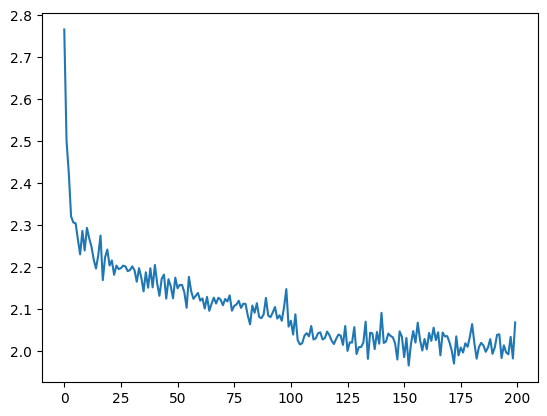

In [80]:
import matplotlib.pyplot as plt
plt.plot(torch.tensor(lossi).view(-1, 100).mean(dim=1))

In [13]:
# put layers into eval mode
for layer in model.layers:
    layer.training = False

In [79]:
# eval the loss

@torch.no_grad()  # no gradient computation
def split_loss(split):
    x, y = {
        'train': (Xtrain, Ytrain),
        'dev': (Xdev, Ydev),
        'test': (Xtest, Ytest)
    }[split]
    logits = model(x)
    loss = torch.nn.functional.cross_entropy(logits, y)
    print(split, loss.item())


split_loss('train')
split_loss('dev')

train 1.9949228763580322
dev 2.032686471939087


In [67]:
# sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        p = torch.nn.functional.softmax(logits, dim=-1)
        ix = torch.multinomial(p, 1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print("".join(itos[i] for i in out))

len.
joely.
wish.
mer.
c.
vri.
zeco.
h.
p.
or.
s.
me.
y.
d.
bem.
xeniv.
ny.
rjynyon.
ri.
jevi.
